In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import GPr
from tools import bin_data, simple_acf
import triangle
from Kepler_ACF import corr_run

Load example data set

(0, 10)

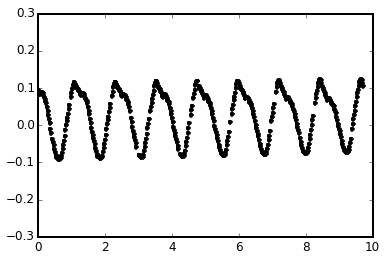

In [3]:
id = "0"
x, y = np.genfromtxt("simulations/%s.txt" % id).T
yerr = np.ones_like(y) * 1e-10  # make up some uncertainties
plt.plot(x, y, "k.")
plt.xlim(0, 10)

Measure the rotation period using the ACF method in order to get a rough guess

1.16471805


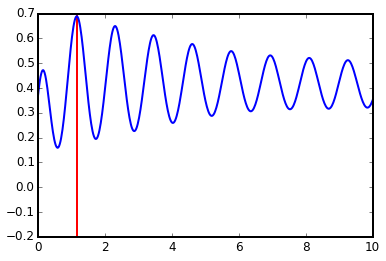

In [4]:
kepler_cadence = .02043365
p_init, acf, lags = simple_acf(x, y, kepler_cadence)
print p_init
plt.xlim(0, 10)
plt.axvline(p_init, color="r")
plt.plot(lags, acf)

Truncate and bin data for speed

In [5]:
npts = int(p_init / 10. * 48)  # 10 points per period
xb, yb, yerrb = bin_data(x, y, yerr, npts)
cutoff = 100
m = xb < cutoff
xb, yb, yerrb = xb[m], yb[m], yerrb[m]

Run the MCMC

In [7]:
gpr = GPr.GProtation(xb, yb, yerrb)
theta_init = [-5., 6., 1.2, -16., np.log(p_init)]  # initial parameter values
plims = np.log([p_init*.7, p_init*1.5])  # use .7 and 1.5 times p_init as bounds on the log-uniform prior.
burnin, nsteps, nwalkers = 1000, 3000, 32  # number of steps for burn-in, full run and the number of walkers.
sampler = gpr.MCMC(theta_init, plims, burnin, nsteps, nwalkers);

burning in...
production run...
emcee: Exception while calling your likelihood function:

Traceback (most recent call last):
  File "build/bdist.macosx-10.5-x86_64/egg/emcee/ensemble.py", line 505, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "GPr.py", line 80, in lnprob
    return self.lnlike(theta) + self.lnprior(theta, plims)
  File "GPr.py", line 103, in lnlike
    gp.compute(self.x, np.sqrt(theta[3]+self.yerr**2))
  File "/Users/tdm/anaconda/lib/python2.7/site-packages/george/gp.py", line 185, in compute
    self.solver.compute(self._x, self._yerr, **kwargs)
  File "/Users/tdm/anaconda/lib/python2.7/site-packages/george/basic.py", line 69, in compute
    self._factor = (cholesky(K, overwrite_a=True, lower=False), False)
  File "/Users/tdm/anaconda/lib/python2.7/site-packages/scipy/linalg/decomp_cholesky.py", line 81, in cholesky
    check_finite=check_finite)



  params: [ -6.6670702    7.00908951  -0.32764274 -10.24632476   0.1796092 ]
  args: [array([-0.2041959 ,  0.55794415])]
  kwargs: {}
  exception:


  File "/Users/tdm/anaconda/lib/python2.7/site-packages/scipy/linalg/decomp_cholesky.py", line 28, in _cholesky
    c, info = potrf(a1, lower=lower, overwrite_a=overwrite_a, clean=clean)
KeyboardInterrupt


KeyboardInterrupt: 

Make triangle plot

In [ ]:
ndims = np.shape(sampler)[-1]
flat = np.reshape(sampler, (nwalkers * nsteps, ndims))
mcmc_result = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(flat, [16, 50, 84], axis=0)))
print mcmc_result
mcmc_result = np.array([i[0] for i in mcmc_result])
print mcmc_result
print "period (days) = ", np.exp(np.array(mcmc_result[-1]))

#fig_labels = ["A", "l2", "l1", "s", "P"]
#fig = triangle.corner(flat, labels=fig_labels)

Plot the prediction from the posterior median values 

In [ ]:
theta = np.exp(np.array(mcmc_result))
k = theta[0] * ExpSquaredKernel(theta[1]) * ExpSine2Kernel(theta[2], theta[4])
gp = george.GP(k)
gp.compute(x, yerr)
xs = np.linspace(x[0], x[-1], 1000)
mu, cov = gp.predict(y, xs)

plt.errorbar(x, y, yerr=yerr, **reb)
plt.xlabel("Time (days)")
plt.ylabel("Normalised Flux")
plt.plot(xs, mu)